In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
%matplotlib inline

/home/michael/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [46]:
playerdf = pd.read_pickle('data/playerdataraw.pkl')
advstatsdf = pd.read_pickle('data/advstatsdataraw.pkl')
colstatsdf = pd.read_pickle('data/colstatsdataraw.pkl')

In [47]:
playerdf = playerdf.reset_index(drop=True)
advstatsdf = advstatsdf.reset_index(drop=False)
colstatsdf = colstatsdf.reset_index(drop=False)

In [48]:
advstatsdf = advstatsdf.rename(columns={'index': 'year'})
advstatsdf['year'] = advstatsdf['year'] + 1

In [49]:
colstatsdf = colstatsdf.rename(columns={'index': 'year'})
colstatsdf['year'] = colstatsdf['year'] + 1

In [254]:
test = advstatsdf[advstatsdf['player']=='Michael Jordan']
test

,year,3PAr,AST%,Age,BLK%,BPM,DBPM,DRB%,DWS,FTr,...,Season,TOV%,TRB%,TS%,Tm,USG%,VORP,WS,WS/48,player
12766,1,0.032,25.3,21.0,1.3,8.2,1.4,13.2,3.7,0.459,...,1984-85,13.0,9.8,0.592,CHI,29.8,8.1,14.0,0.213,Michael Jordan
12767,2,0.055,21.7,22.0,2.7,4.7,-0.5,10.7,0.5,0.381,...,1985-86,10.5,8.0,0.533,CHI,38.6,0.8,1.5,0.160,Michael Jordan
12768,3,0.029,22.2,23.0,2.3,8.6,0.6,9.3,5.0,0.427,...,1986-87,9.1,7.4,0.562,CHI,38.3,8.8,16.9,0.247,Michael Jordan
12769,4,0.027,27.0,24.0,2.4,12.2,2.3,10.7,6.1,0.430,...,1987-88,9.6,7.8,0.603,CHI,34.1,11.8,21.2,0.308,Michael Jordan
12770,5,0.055,34.7,25.0,1.2,12.6,2.7,17.3,5.2,0.442,...,1988-89,11.9,11.6,0.614,CHI,32.1,12.0,19.8,0.292,Michael Jordan
12771,6,0.125,28.6,26.0,1.1,10.6,0.8,15.6,4.3,0.356,...,1989-90,9.8,10.4,0.606,CHI,33.7,10.1,19.0,0.285,Michael Jordan
12772,7,0.051,25.2,27.0,1.7,10.8,1.8,14.3,5.4,0.365,...,1990-91,8.7,9.5,0.605,CHI,32.9,9.8,20.3,0.321,Michael Jordan
12773,8,0.055,25.7,28.0,1.5,8.6,1.7,15.3,5.6,0.325,...,1991-92,8.8,9.5,0.579,CHI,31.7,8.3,17.7,0.274,Michael Jordan
12774,9,0.115,25.2,29.0,1.3,9.5,1.2,15.1,5.2,0.284,...,1992-93,8.4,9.8,0.564,CHI,34.7,8.9,17.2,0.270,Michael Jordan
12775,10,0.079,24.2,31.0,1.5,2.7,0.7,16.2,1.1,0.337,...,1994-95,7.0,10.3,0.493,CHI,33.2,0.8,2.3,0.167,Michael Jordan


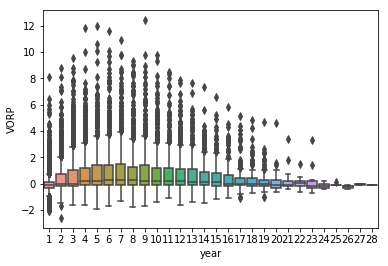

In [56]:
sns.boxplot(x="year", y="VORP", data=advstatsdf);

In [171]:
playeravgvorp = advstatsdf.groupby(['player'],as_index=False)[['VORP']].mean()
playeravgvorp = playeravgvorp.rename(columns = {'VORP':'avgVORP'})
playeravgvorp.sort_values('avgVORP',ascending=False).head(10)

,player,avgVORP
1229,LeBron James,8.060000
1387,Michael Jordan,6.966667
1208,Larry Bird,6.123077
1281,Magic Johnson,5.953846
279,Charles Barkley,5.843750
475,David Robinson,5.778571
321,Chris Paul,5.700000
1090,Karl Malone,5.400000
1723,Russell Westbrook,5.320000
853,James Harden,5.111111


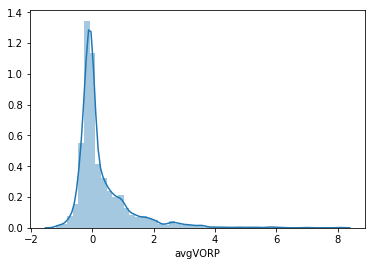

In [196]:
sns.distplot(playeravgvorp.avgVORP, hist=True, kde=True);

In [231]:
playerstartage = advstatsdf.groupby(['player'],as_index = False)[['Age']].min()
playerpos = advstatsdf.groupby(['player','Pos'],as_index = False)['year'].count()
playerpos['count_max'] = playerpos.groupby(['player'])['year'].transform(max)
playerpos = playerpos[playerpos['year'] == playerpos['count_max']]
playerpos = playerpos[['player','Pos']]

In [234]:
playerdatafull = pd.merge(playerdf,playeravgvorp,how='inner')
playerdatafull = pd.merge(playerdatafull,playerstartage,how='inner')
playerdatafull = pd.merge(playerdatafull,playerpos,how='inner')
playerdatafull.sort_values('avgVORP',ascending=False).head(20)

,player,height,weight,draftnbr,draftyr,recruitnbr,urlx,avgVORP,Age,Pos
746,LeBron James,6.666667,250,1,2003,1,/players/j/jamesle01.html,8.060000,19.0,SF
1743,Michael Jordan,6.500000,195,3,1984,0,/players/j/jordami01.html,6.966667,21.0,SG
2103,Larry Bird,6.750000,220,6,1978,0,/players/b/birdla01.html,6.123077,23.0,SF
2046,Magic Johnson,6.750000,215,1,1979,0,/players/j/johnsma02.html,5.953846,20.0,PG
1745,Charles Barkley,6.500000,252,5,1984,0,/players/b/barklch01.html,5.843750,21.0,PF
1551,David Robinson,7.083333,235,1,1987,0,/players/r/robinda01.html,5.778571,24.0,C
640,Chris Paul,6.000000,175,4,2005,6,/players/p/paulch01.html,5.700000,20.0,PG
1689,Karl Malone,6.750000,250,13,1985,0,/players/m/malonka01.html,5.400000,22.0,PF
474,Russell Westbrook,6.250000,200,4,2008,0,/players/w/westbru01.html,5.320000,20.0,PG
421,James Harden,6.416667,220,3,2009,17,/players/h/hardeja01.html,5.111111,20.0,SG


In [236]:
playerdatafull = playerdatafull[playerdatafull['draftnbr']<31]
playerdatafull = playerdatafull[playerdatafull['draftyr']<2013]

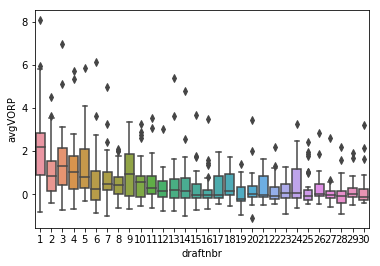

In [237]:
sns.boxplot(x="draftnbr", y="avgVORP", data=playerdatafull);

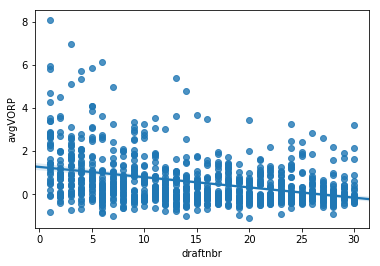

In [170]:
sns.regplot(x="draftnbr", y="avgVORP", data=playerdatafull);

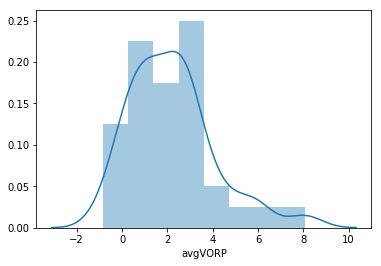

In [239]:
firstpickdraftvorpavg = playerdatafull[playerdatafull['draftnbr']==1]
sns.distplot(firstpickdraftvorpavg.avgVORP, hist=True, kde=True);

In [249]:
modeldata = playerdatafull[['draftnbr','Age','Pos','height','avgVORP']]
modeldata = pd.get_dummies(modeldata, drop_first = True)
modeldata.head()

,draftnbr,Age,height,avgVORP,Pos_PF,Pos_PG,Pos_SF,Pos_SG
228,14,21.0,6.000000,1.740909,0,1,0,0
256,1,19.0,6.833333,3.400000,1,0,0,0
257,2,19.0,6.583333,0.433333,0,0,1,0
258,3,19.0,6.416667,1.316667,0,0,0,1
259,4,21.0,6.333333,-0.312500,0,0,0,1


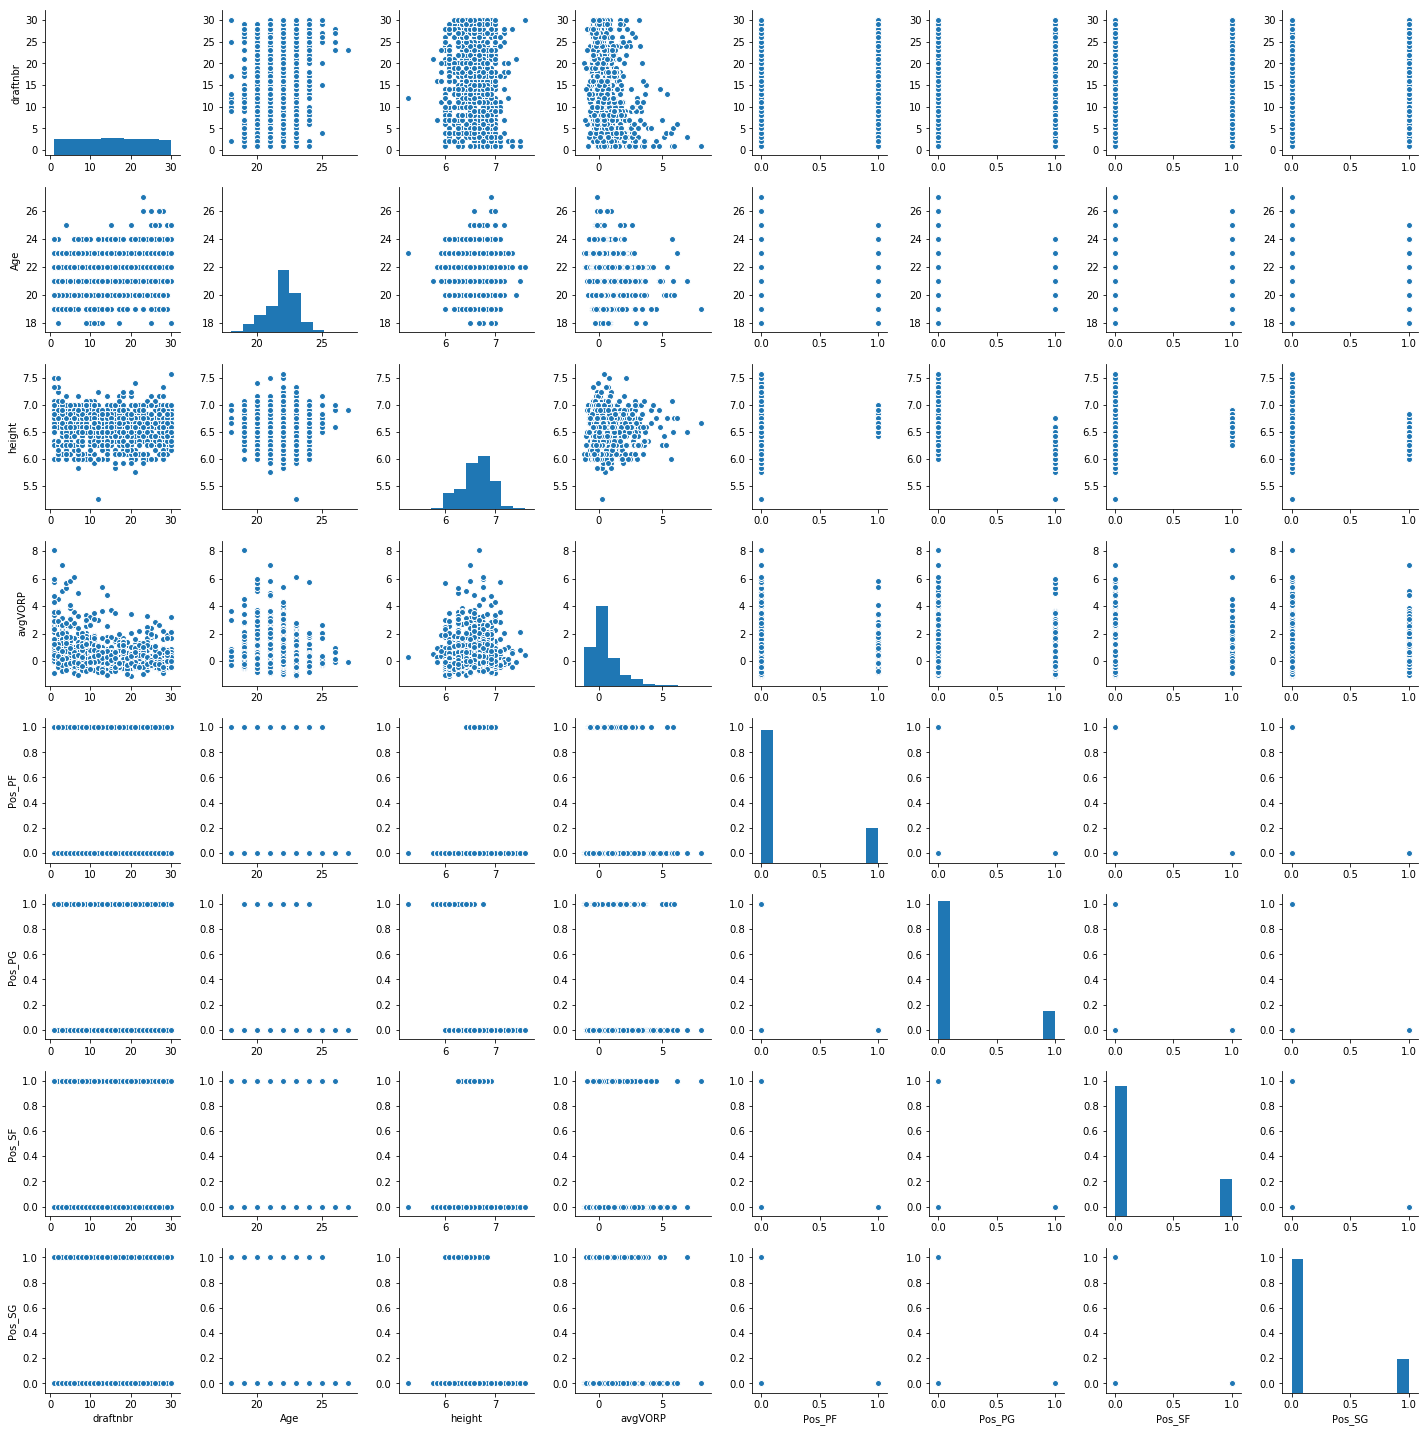

In [250]:
sns.pairplot(modeldata);

In [164]:
X = np.array(firstroundplayerdraftvorpavg['draftnbr'])
X = np.c_[np.ones(X.shape[0]), X]
y = np.array(firstroundplayerdraftvorpavg['avgVORP'])

In [165]:
def ols(X, y):
    '''returns parameters based on Ordinary Least Squares.'''
    xtx = np.dot(X.T, X) ## x-transpose times x
    inv_xtx = np.linalg.inv(xtx) ## inverse of x-transpose times x
    xty = np.dot(X.T, y) ## x-transpose times y
    return np.dot(inv_xtx, xty)

In [166]:
# find parameters
params = ols(X,y)
print('intercept: {} | slope: {}'.format(params[0], params[1]))

intercept: 1.261999490063956 | slope: -0.047425207756236334


In [181]:
model = pd.DataFrame()
model['X'] = firstroundplayerdraftvorpavg['draftnbr']
model['y'] = firstroundplayerdraftvorpavg['avgVORP']
model['yhat'] = (params[1]*firstroundplayerdraftvorpavg['draftnbr']) + params[0]
model['residuals'] = model['yhat'] - model['y']
model['sst'] = model['y'] - model['y'].mean()
model.head()

,X,y,yhat,residuals,sst
223,14,1.740909,0.598047,-1.142863,1.203613
251,1,3.400000,1.214574,-2.185426,2.862704
252,2,0.433333,1.167149,0.733816,-0.103963
253,3,1.316667,1.119724,-0.196943,0.779371
254,4,-0.312500,1.072299,1.384799,-0.849796


In [185]:
sse = sum(model['residuals']**2)
sst = sum(model['sst']**2)
rsq = 1 - (sse/sst)
rsq

0.13703097524850194

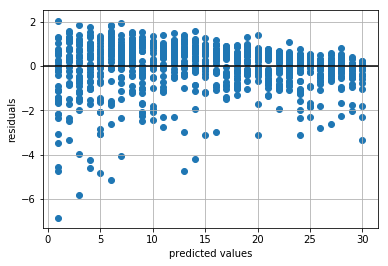

In [175]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
axes.scatter(model['X'],model['residuals'])
axes.axhline(y=0, color='k')
axes.grid()
axes.set_xlabel('predicted values')
axes.set_ylabel('residuals');

In [189]:
X_log = np.log10(np.array(X)+1e1)
y_log = np.log10(np.array(y)+1e1)

In [195]:
logreg = LinearRegression()
logreg.fit(X_log,y_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)